In [1]:
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset


  0%|          | 0.00/67.4k [00:00<?, ?B/s]
100%|##########| 67.4k/67.4k [00:00<00:00, 69.3MB/s]


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
import zipfile
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,OrdinalEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier,VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score,confusion_matrix,plot_confusion_matrix,classification_report,accuracy_score,recall_score,precision_score
from imblearn.over_sampling import RandomOverSampler

### Unzip data

In [4]:
with zipfile.ZipFile('stroke-prediction-dataset.zip') as file:
    file.extractall()

## Data information


In [5]:
stroke_data=pd.read_csv('healthcare-dataset-stroke-data.csv')

In [6]:
stroke_data.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [8]:
stroke_data_replaced=stroke_data.copy()

In [9]:
stroke_data_replaced.fillna(value=stroke_data_replaced.mean(axis=0),
                            axis=0,
                            inplace=True)

C:\Users\Nitesh\AppData\Local\Temp/ipykernel_7220/59667440.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stroke_data_replaced.fillna(value=stroke_data_replaced.mean(axis=0),


In [10]:
for col in ['hypertension','heart_disease','stroke']:
    stroke_data_replaced[col]=stroke_data_replaced[col].replace([0,1],['No','Yes'])

In [11]:
stroke_data_replaced.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.600000,formerly smoked,Yes
1,51676,Female,61.0,No,No,Yes,Self-employed,Rural,202.21,28.893237,never smoked,Yes
2,31112,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.500000,never smoked,Yes
3,60182,Female,49.0,No,No,Yes,Private,Urban,171.23,34.400000,smokes,Yes
4,1665,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.000000,never smoked,Yes


In [12]:
stroke_data_replaced.describe()

,id,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,106.147677,28.893237
std,21161.721625,22.612647,45.283560,7.698018
min,67.000000,0.080000,55.120000,10.300000
25%,17741.250000,25.000000,77.245000,23.800000
50%,36932.000000,45.000000,91.885000,28.400000
75%,54682.000000,61.000000,114.090000,32.800000
max,72940.000000,82.000000,271.740000,97.600000


In [13]:
stroke_data_replaced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   object 
 4   heart_disease      5110 non-null   object 
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 479.2+ KB


In [14]:
categorical_col=[]
numerical_col=[]
for col in stroke_data_replaced.dtypes.index:
    if stroke_data_replaced[col].dtype == 'object':
        categorical_col.append(col)
    else:
        numerical_col.append(col)

In [15]:
print("Numerical Columns in DataFrame are :",numerical_col, '\n')
print("Categorical Columns in DataFrame are :",categorical_col)

Numerical Columns in DataFrame are : ['id', 'age', 'avg_glucose_level', 'bmi'] 

Categorical Columns in DataFrame are : ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']


<AxesSubplot:xlabel='stroke', ylabel='count'>

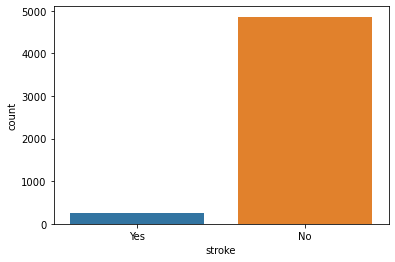

In [16]:
sns.countplot(x='stroke',data = stroke_data_replaced)

We can see the data is highly imbalanced so we have to use data imbalance techniques to maintain data stability

##  Visulization

In [17]:
def bar_plot(data,x,y='id',hue='stroke',group='stroke' ,title=None):
    """
        function use to plot barplot by grouping the data

    """
    try:
        group=data.groupby([x,group],as_index=False)['id'].count()
        sns.barplot(data=group,x=x,y=y,hue=hue,)
        plt.title("Stroke count based on "+ x , fontdict={'size' :16,'color':'red'})
        plt.ylabel('Count',fontdict={'size':12,'color':'blue'})
        plt.xlabel(x,fontdict={'size':12,'color':'blue'})
        print('-'*100)
        return display(group) ,plt.show()
    except:
        pass

----------------------------------------------------------------------------------------------------


,gender,stroke,id
0,Female,No,2853
1,Female,Yes,141
2,Male,No,2007
3,Male,Yes,108
4,Other,No,1


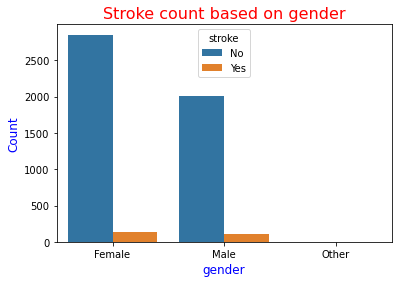

----------------------------------------------------------------------------------------------------


,hypertension,stroke,id
0,No,No,4429
1,No,Yes,183
2,Yes,No,432
3,Yes,Yes,66


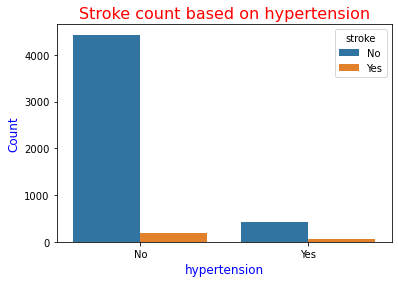

----------------------------------------------------------------------------------------------------


,heart_disease,stroke,id
0,No,No,4632
1,No,Yes,202
2,Yes,No,229
3,Yes,Yes,47


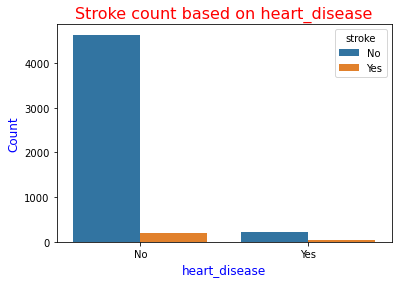

----------------------------------------------------------------------------------------------------


,ever_married,stroke,id
0,No,No,1728
1,No,Yes,29
2,Yes,No,3133
3,Yes,Yes,220


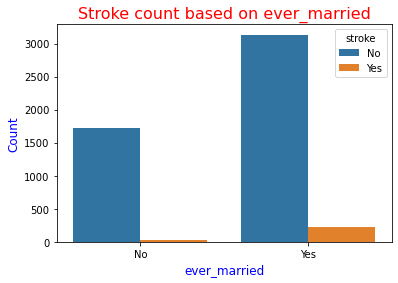

----------------------------------------------------------------------------------------------------


,work_type,stroke,id
0,Govt_job,No,624
1,Govt_job,Yes,33
2,Never_worked,No,22
3,Private,No,2776
4,Private,Yes,149
5,Self-employed,No,754
6,Self-employed,Yes,65
7,children,No,685
8,children,Yes,2


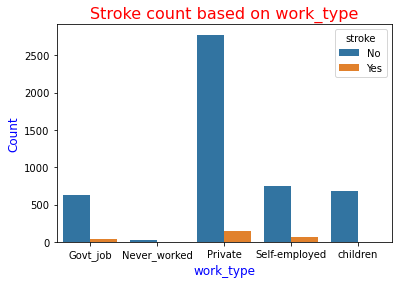

----------------------------------------------------------------------------------------------------


,Residence_type,stroke,id
0,Rural,No,2400
1,Rural,Yes,114
2,Urban,No,2461
3,Urban,Yes,135


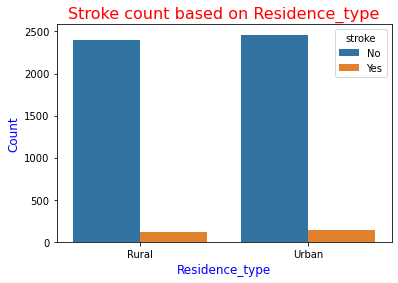

----------------------------------------------------------------------------------------------------


,smoking_status,stroke,id
0,Unknown,No,1497
1,Unknown,Yes,47
2,formerly smoked,No,815
3,formerly smoked,Yes,70
4,never smoked,No,1802
5,never smoked,Yes,90
6,smokes,No,747
7,smokes,Yes,42


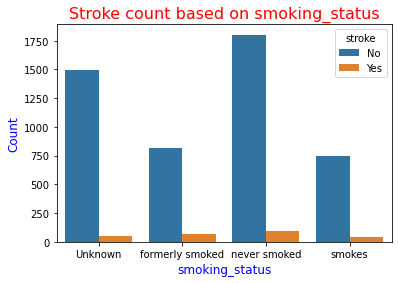

In [18]:
for col in categorical_col:
    bar_plot(stroke_data_replaced,col)

Things that can be assumed on the basis of above plots:
- Stroke Count based on gender
    
    - it is around 5% for males and 4% for females those have been struggling with stroke
    
    - this can be the important feature as 1% is a significant drop
    

- Stroke Count based on hypertension

    - It is found to be person tested with hypertension is more likely to be stroked (~ 13%)
    

    - and this is also accepted by having some prior domain knowledge
    
    
- Stroke Count based on heart_disease


    - It is found to be person with heart disease are at high risk of stroke (~ 17%)
    

    - This is also accepted by having some prior domain knowlegde
    

- Stroke Count Based on maritial Status


    - 6% of married people have faced stroke
    

    - also is it to be notice that we have more baised data around the married people nearly 2000 more entries married people
    

    - This need to be investigated further
    

- Stroke count Based on Work Type


    - Based on the data it is seen that there are more number of records for private sector jobs
    

    - It can be possible that people having govt job are more relived than people with private jobs but on other have people having no job don't have stroke who should probaly be more worried about getting a job
    

    - And children are being tested positive for stroke
    

    - Conclusively Stroke doesn't depends on Work Type
    

- Stroke based on Residence Type


    - People living in Urban Areas have !% more Stroke than People Living in Rural areas
    

    - Urban areas have more Pollution level and Busy life style which can have great impact on the health of a person
    

- Stroke Count Based on Smoking Status


    - Similary for people who formerly smoked or smokes have more chances to get Stroke than people who doesn't
    

    - It is un predictable for the people with Unknown Status
    



By above Study it is clear that we are going to drop the featue Work Type as it doesn't contribute to prediction

And The Featue Maritial Status need to be further investigated

In [19]:
Feature_to_drop=['work_type']

In [20]:
def scatter_plot(data,x,y='stroke',title=None):
    plt.figure(figsize=(10,7))
    plt.title("Relationship of "+ y + " v/s "+ x , fontdict={'size':18,'color':'red'})
    sns.scatterplot(data=data,x=x,y='stroke')
    plt.xlabel(x,fontdict={'size':12,"color":'blue'})
    plt.ylabel(y,fontdict={'size':12,"color":'blue'})
    print('-'*100)
    return plt.show()

----------------------------------------------------------------------------------------------------


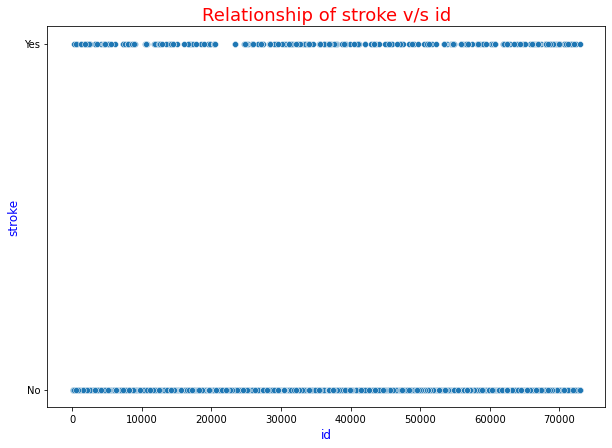

----------------------------------------------------------------------------------------------------


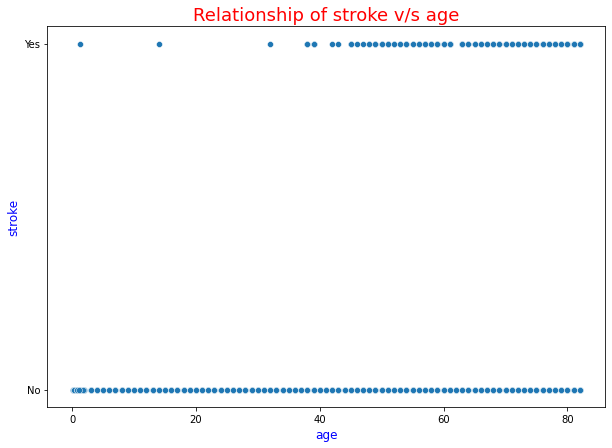

----------------------------------------------------------------------------------------------------


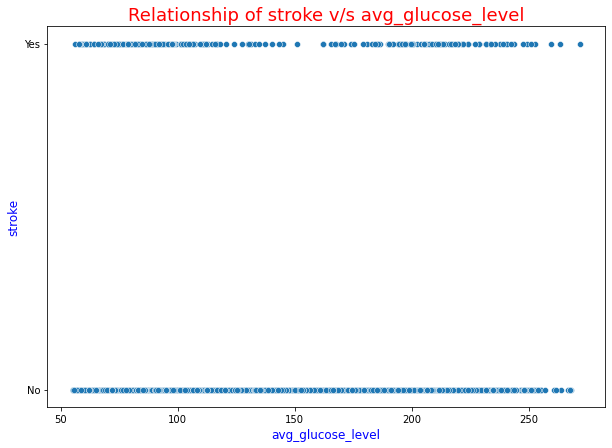

----------------------------------------------------------------------------------------------------


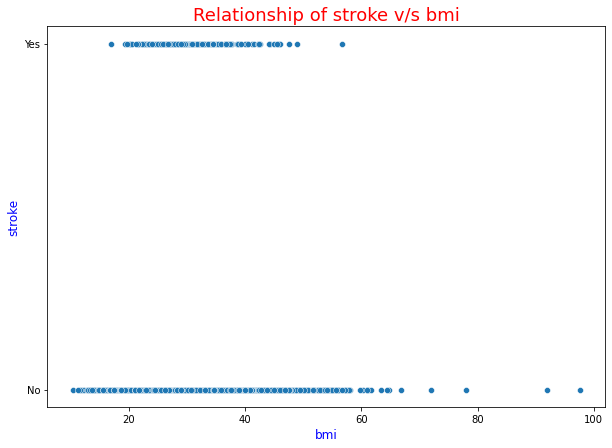

In [21]:
for col in numerical_col:
    scatter_plot(stroke_data_replaced,col)

Things that can be assumed on the basis of above plots:

- Relationship of Stroke and id

    - this feature id is totally irrelavent for prediction purpose as it add no information to the data
    
    - every person will have different id and no pattern will be formed
        
- Relationship of Stroke and age
    - According to the trend elder people will have high risk of getting stroked
    
- Relationship of Stroke and average glucose level 

    - People having glucose level around 150 mg/dl are less prone to get stroke

    - while people having more or less than this are more prone for stroke
- Relationship of Stroke and average BMI
    - we can't really tell if this is a good predictor or not
    - further investgation is needed

In [22]:
stroke_data_replaced.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.600000,formerly smoked,Yes
1,51676,Female,61.0,No,No,Yes,Self-employed,Rural,202.21,28.893237,never smoked,Yes
2,31112,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.500000,never smoked,Yes
3,60182,Female,49.0,No,No,Yes,Private,Urban,171.23,34.400000,smokes,Yes
4,1665,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.000000,never smoked,Yes


In [23]:
Feature_to_drop.append('id')

In [24]:
stroke_data_replaced.drop(Feature_to_drop,axis=1,inplace=True)

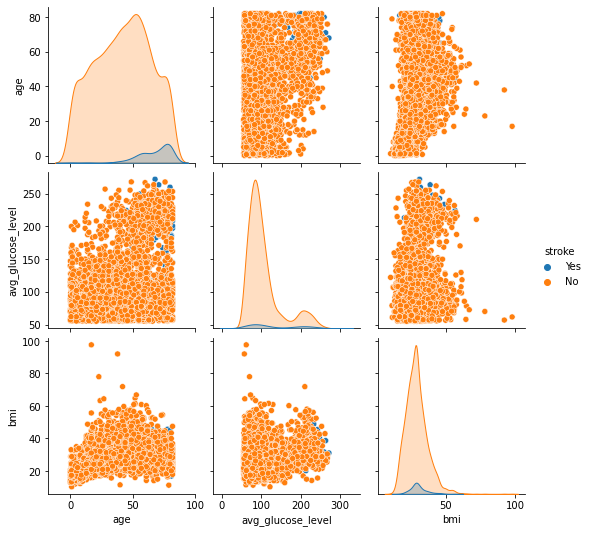

In [25]:
sns.pairplot(stroke_data_replaced,hue='stroke')

In [26]:
sample=stroke_data_replaced.sample(n=100,random_state=72018,)
sample.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
485,Female,31.0,No,No,Yes,Urban,98.99,31.2,never smoked,No
871,Female,62.0,Yes,No,Yes,Rural,77.04,34.7,never smoked,No
1125,Female,59.0,Yes,No,No,Rural,57.26,23.5,never smoked,No
3347,Male,80.0,No,No,Yes,Urban,148.72,28.7,never smoked,No
2427,Female,37.0,No,No,No,Rural,77.37,21.4,never smoked,No


In [27]:
def outlier_detection(data,x):
    plt.figure(figsize=(10,7))
    plt.title("Outliers for " + x , fontdict={'size':18,'color':'red'})
    sns.boxplot(data=data,x=x)
    plt.xlabel(x,fontdict={'size':12,"color":'blue'})
    print('-'*100)
    return plt.show()

----------------------------------------------------------------------------------------------------


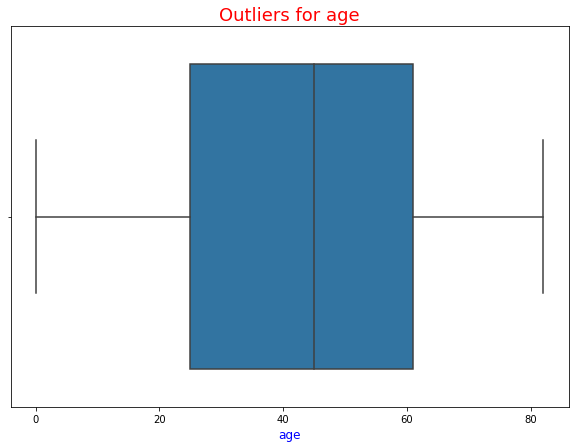

----------------------------------------------------------------------------------------------------


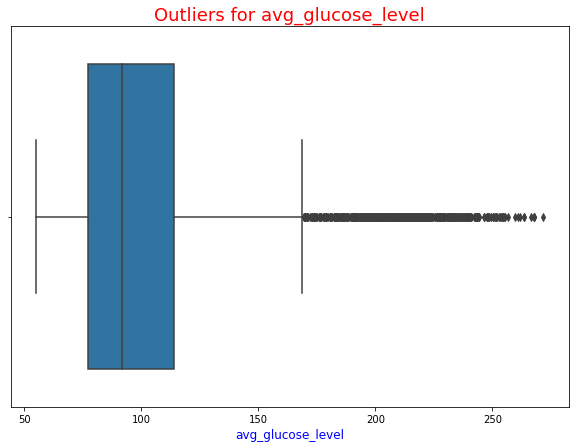

----------------------------------------------------------------------------------------------------


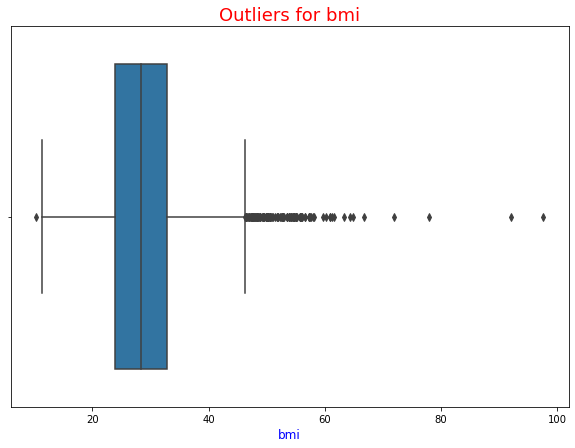

In [28]:
for i in numerical_col:
    if i!='id':
        outlier_detection(stroke_data_replaced,i)

From this we can see clearly the Column bmi and average glucose level have a lot of outliers we can handle this with suitable techniques like replacing it with mean or median or dropping in in this case we are ieabing these outliers as it is.

In hope that an extreme behaviour target variable are highly dependent on the pattern of these features

### Data Transformation


In [29]:
#this wil masl the categorical columns
mask = stroke_data_replaced.dtypes == np.object_

In [30]:
#here we separate the numerical and categorical columns
categorical_col = stroke_data_replaced.columns[mask.values]
numerical_col = stroke_data_replaced.columns[~mask.values]

In [31]:
#now separate ordinal and onehot columns
#here by the visulization we know our ordinal column have >2 variables

onehot_categorical_columns=[]
ordinal_categorical_columns=[]
for i in categorical_col:
    if stroke_data_replaced[i].nunique()<3:
        onehot_categorical_columns.append(i)
    else:
        ordinal_categorical_columns.append(i)

In [32]:
#this version of scikit-learn doesn't support the handle unknown option for ordinal encoder so this will replace ordinal encoder
converter={'gender':{'Other':0,'Male':1,'Female':2},'smoking_status':{'formerly smoked':1, 'never smoked':2, 'smokes':3, 'Unknown':4}}
for i in ordinal_categorical_columns:
    stroke_data_replaced[i]=stroke_data_replaced[i].map(converter[i])

In [33]:
#Create our transformers that will transform the columns 
#oridnal transformer
#OD=OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=5)

#min max scaler
MM=MinMaxScaler()

#label encoder for target variable
LE=LabelEncoder()

#one hot encoded column
OHE=OneHotEncoder(handle_unknown='ignore')

In [34]:
#traget variable
y=stroke_data_replaced['stroke']

#remove from onehot columns
onehot_categorical_columns.remove('stroke')

In [35]:
#create column transformer that will transform the columns respective to the criteria
#transformer=ColumnTransformer(transformers=[('numerical',MM,numerical_col),
#                                            ('ordinal',OD,ordinal_categorical_columns),
#                                            ('onehot',OHE,onehot_categorical_columns)])

#use te transformer above if you are using ordinal_encoder
transformer=ColumnTransformer(transformers=[('numerical',MM,numerical_col),('onehot',OHE,onehot_categorical_columns)])

In [36]:
#feature columns
X=stroke_data_replaced.drop('stroke',axis=1)

In [37]:
#used for oversampling the data as it is highly imbalanced
ROS=RandomOverSampler(random_state=42)

In [38]:
def transform_and_resample_data(X,y):
    """
    It accepts feature column and target column.
    split the data int train and test set in stratify manner.
    transform the target with label encoder
    over sample the target set.
    return train set and test set
    """
    
    train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    train_y = LE.fit_transform(train_y)
    test_y = LE.transform(test_y)
    train_X_resampled , train_y_resampled = ROS.fit_resample(train_X,train_y)


    return train_X_resampled,train_y_resampled,test_X,test_y

### Model traning and prediction


In [39]:
def prune_tree(train_X,train_y,transformer):
    """
    accepts the model and train data.
    fit to Decision tree return the required parameter. 
    
    It is used to prune the tree to generate range of the parameters.
    """
    model = DecisionTreeClassifier(criterion='gini',random_state=42)
    
    pipeline=Pipeline(steps=[('transform',transformer),
                             ('model',model)])
    
    pipeline.fit(train_X,train_y)
    return model.tree_.max_depth,model.tree_.n_features

In [40]:
def model_selection(train_X,train_y,transformer,current=None):
    """
    It is used to select different models for traning purpose based in the value of current.
    
    """
    if current == 0:
        
        label='Logistic Regression'
        model = LogisticRegression(solver='liblinear')
        params = {'model__C':[0.001,0.01,0.1,1,10],
               'model__penalty':['l1','l2']}
        
    elif current == 1:
        
        label = 'KNeighborsClassifier'
        model = KNeighborsClassifier(weights='distance')
        params = {'model__n_neighbors':list(range(2,20))}
        
    elif current == 2:
        
        label = 'SVC'
        model = SVC(kernel='rbf')
        params = {'model__C':[0.001,0.01,0.1,1,10]}
        
    elif current == 3:
        
        label = 'DecisionTreeClassifier'
        model = DecisionTreeClassifier(criterion='entropy',random_state=42)
        max_depth, max_features = prune_tree(train_X,train_y,transformer)
        params = {'model__max_depth':list(range(1,max_depth+1,2)),
                 'model__max_features':list(range(1,max_features))}
        
    else:
        raise ValueError('No value passed for current')
        
    return model, params, label

In [41]:
def scoring(model , params, true, pred):
    """
    It is used to score the model based on its preformance 
    Accepts model , parameter, original labels and predicted labels
    
    """
    re_Y = recall_score(true, pred, pos_label=1)
    re_N = recall_score(true, pred, pos_label=0)
    pr_Y = precision_score(true, pred, pos_label=1)
    pr_N = precision_score(true, pred, pos_label=0)
    f1_Y = f1_score(true, pred, pos_label=1)
    f1_N = f1_score(true, pred, pos_label=0)
    acc = accuracy_score(true, pred)
    data = pd.Series({'model':model,
                      'params': params,
                      'recall_Yes': re_Y,
                      'recall_No': re_N,
                      'precision_Yes':pr_Y,
                      'precision_No':pr_N,
                      'f1_Yes':f1_Y,
                      'f1_No':f1_N,
                      'accuracy':acc})
    
    return data

In [42]:
#final dataframe which will store the performance of the model
performance =  pd.DataFrame(columns=['model','params','recall_Yes','recall_No','precision_Yes','precision_No','f1_Yes','f1_No','accuracy'])

#get train and test set
train_X,train_y,test_X,test_y = transform_and_resample_data(X,y)

#call different model fir training and testing
for i in range(4):
    
    model, param, label = model_selection(train_X, train_y, transformer, current=i)
    pipeline = Pipeline(steps = [('transform',transformer),
                             ('model',model)])
    
    #score metric 
    score = {'r':'recall','p':'precision'} 
    grid = GridSearchCV(pipeline,param,cv=4,scoring=score, refit='r')
    
    grid.fit(train_X,train_y)
    
    pred = grid.predict(test_X)
    
    para = grid.best_estimator_.named_steps['model']
    
    performance = performance.append(scoring(label, para, test_y, pred),ignore_index=True)

    string = 'This results are for '+label
    print(19*'* '+string+19*' *')
    print('----- Classification report -----')
    print(classification_report(test_y,pred))
    print('----- Confusion matrix -----')
    print(confusion_matrix(test_y,pred))

* * * * * * * * * * * * * * * * * * * This results are for Logistic Regression * * * * * * * * * * * * * * * * * * *
----- Classification report -----
              precision    recall  f1-score   support

           0       0.98      0.67      0.80       972
           1       0.11      0.76      0.19        50

    accuracy                           0.67      1022
   macro avg       0.54      0.71      0.49      1022
weighted avg       0.94      0.67      0.77      1022

----- Confusion matrix -----
[[650 322]
 [ 12  38]]
* * * * * * * * * * * * * * * * * * * This results are for KNeighborsClassifier * * * * * * * * * * * * * * * * * * *
----- Classification report -----
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       972
           1       0.13      0.10      0.11        50

    accuracy                           0.92      1022
   macro avg       0.54      0.53      0.54      1022
weighted avg       0.91      0.92      0.92   

In [43]:
performance

,model,params,recall_Yes,recall_No,precision_Yes,precision_No,f1_Yes,f1_No,accuracy
0,Logistic Regression,"LogisticRegression(C=0.001, solver='liblinear')",0.76,0.668724,0.105556,0.981873,0.185366,0.795594,0.673190
1,KNeighborsClassifier,"KNeighborsClassifier(n_neighbors=2, weights='d...",0.10,0.965021,0.128205,0.954222,0.112360,0.959591,0.922701
2,SVC,SVC(C=0.01),0.82,0.659465,0.110215,0.986154,0.194313,0.790382,0.667319
3,DecisionTreeClassifier,"DecisionTreeClassifier(criterion='entropy', ma...",0.34,0.916667,0.173469,0.964286,0.229730,0.939873,0.888454


observing recall, precision and accuracy of SVC is higher than everyone else.

while KNeighborsClassifier perform the worst.

### Voting classifier

In [44]:
#getting our model we want to use fr voting
v_1,v_2,v_3,v_4 = performance['params'].values

In [45]:
#models for voting
estimators = [('lr',v_1),('svc',v_3),('dt',v_4)]

In [46]:
#voting model
vote = VotingClassifier(estimators,voting='hard')
pipeline = Pipeline(steps = [('transform',transformer),
                             ('model',vote)])


In [47]:
#fit the model
pipeline.fit(train_X,train_y)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                                  Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hypertension',
                                                   'heart_disease',
                                                   'ever_married',
                                                   'Residence_type'])])),
                ('model',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(C=0.001,
                                                                  solver='liblinear')),
                                              ('svc', SVC(C=0.01)),
                                            

In [48]:
#prediction made my the pipeline
pred=pipeline.predict(test_X)

In [49]:
#classification report 
print(classification_report(test_y,pred))

              precision    recall  f1-score   support

           0       0.98      0.71      0.82       972
           1       0.12      0.78      0.21        50

    accuracy                           0.71      1022
   macro avg       0.55      0.74      0.52      1022
weighted avg       0.94      0.71      0.79      1022



C:\Users\Nitesh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


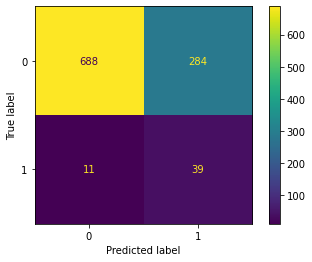

In [50]:
#plot the confusion matrix
plot_confusion_matrix(pipeline,test_X,test_y)

we can see from voting the recall precision and accuray is actualy increased by fine margin.